In [1]:
import tester as t


# lokacija, podatkov
t.lokacija_originalnih_podatkov = r"european_wholesale_electricity_price_data_hourly/Slovenia.csv"
# podatki, se prvič pripravijo nakar ustavrijo mapo logs kjer se shranijo.
t.zacetni_cas = 10_000  # to doloci zadnjih koliko cen bo dobila tvoja funkcija prvic ko bo klicana.
# podatki na eno uro, vesbujejo izključno ceno, dostop do vseh podatkov do (brez) cene, ki jo napovedujemo.

In [2]:
def povprecna_cena_zadnjega_dne(cene):
    return sum(cene[-24:])/24

t.test(povprecna_cena_zadnjega_dne)

test povprecna_cena_zadnjega_dne: povprecna kvadratna napaka: 916.1221461879952 porabljen cas: 0.04327130317687988


In [3]:
def ucerisna_cena(cene):
    return cene[-23]

t.test(ucerisna_cena)

test ucerisna_cena: povprecna kvadratna napaka: 1100.339791453747 porabljen cas: 0.02388453483581543


In [4]:
def zadnja_cena(cene):
    return cene[-1]

t.test(zadnja_cena)

test zadnja_cena: povprecna kvadratna napaka: 242.52700874183904 porabljen cas: 0.03263044357299805


In [5]:
def mehek_moment(cene):
    return (cene[-1] - cene[-2]/8) * 8/7

t.test(mehek_moment)

test mehek_moment: povprecna kvadratna napaka: 228.19934753621536 porabljen cas: 0.028812170028686523


In [6]:
import numpy as np

def linearni_prediktor(cene, n, m=-20000, utezi=[]):
    if not utezi or len(cene) % t.zacetni_cas == 0: # uteži ne posodabljamo vsakič zaradi računske zahtevnosti
        utezi.clear()
        cene = cene[m:]
        matrika_cen = np.array([cene[i:i-n] for i in range(n)])
        b = np.array(cene[n:])
        solution, _, _, _ = np.linalg.lstsq(matrika_cen.T, b, rcond=None)
        for i in solution:
            utezi.append(i)
    return (np.array(cene[-n:]) * np.array(utezi)).sum()


for i in range(12):
    print()
    print(f"umerjena linearna kombinacija {2**i} podatkov")
    t.test(lambda x: linearni_prediktor(x, 2 ** i))



umerjena linearna kombinacija 1 podatkov
test <lambda>: povprecna kvadratna napaka: 241.72067469098712 porabljen cas: 0.2536637783050537

umerjena linearna kombinacija 2 podatkov
test <lambda>: povprecna kvadratna napaka: 223.01902279589694 porabljen cas: 0.2590055465698242

umerjena linearna kombinacija 4 podatkov
test <lambda>: povprecna kvadratna napaka: 220.4891041206481 porabljen cas: 0.2828643321990967

umerjena linearna kombinacija 8 podatkov
test <lambda>: povprecna kvadratna napaka: 207.87221947452431 porabljen cas: 0.32878851890563965

umerjena linearna kombinacija 16 podatkov
test <lambda>: povprecna kvadratna napaka: 194.39478036154333 porabljen cas: 0.41967010498046875

umerjena linearna kombinacija 32 podatkov
test <lambda>: povprecna kvadratna napaka: 152.90698663746775 porabljen cas: 0.630180835723877

umerjena linearna kombinacija 64 podatkov
test <lambda>: povprecna kvadratna napaka: 147.53564795115307 porabljen cas: 1.1549477577209473

umerjena linearna kombinacija 

Ob večjem oknu (trenutno 20_000) bi se napake večjih modelov se še izboljševale. Trenutno degenerirajo, prevč variance/premalo pristanskosti v modelih za to količino podatkov.

In [7]:
# osredotočimo se na dnevno nihanje
# v predoločen sistem dodamo sin(2xpi/k) cos(...) kjer je k = 24 saj imamo urne podatke. dodamo še afin del a_1 * cene[-1]
import random
def ciklicni_prediktor(cene, k, m=-20000, utezi=[]):
    l = len(cene)
    if not utezi or len(cene) % t.zacetni_cas == 0: # uteži ne posodabljamo vsakič zaradi računske zahtevnosti
        utezi.clear()

        t0 = np.linspace(0, 2 * np.pi * len(cene)/k, len(cene))
        t0 = t0[m:]
        cene = cene[m:]
        
        cos_window = np.cos(t0)
        sin_window = np.sin(t0)
        
        matrika_cen = np.array([cene[:-1], cos_window[:-1], sin_window[:-1]])
        b = np.array(cene[1:])
        solution, _, _, _ = np.linalg.lstsq(matrika_cen.T, b, rcond=None)
        for i in solution:
            utezi.append(i)

    return (np.array([cene[-1], np.cos(2 * np.pi * l/k), np.sin(2 * np.pi * l/k)]) * np.array(utezi)).sum()
    # return (np.array([cos_window[-1], sin_window[-1]]) * solution).sum()

for i in [float("inf"), 1, 2, 3, 6, 12, 24, 2 * 24, 7 * 24, 365/12 * 24 ,365.25/4 * 24, 365.25/2 * 24, 365.25 * 24]:
    print()
    print(f"Cikli {i} ur")
    t.test(lambda x: ciklicni_prediktor(x, i))


Cikli inf ur
test <lambda>: povprecna kvadratna napaka: 243.90078917391094 porabljen cas: 0.34963297843933105

Cikli 1 ur
test <lambda>: povprecna kvadratna napaka: 252.1448865700908 porabljen cas: 0.35053563117980957

Cikli 2 ur
test <lambda>: povprecna kvadratna napaka: 241.80141256412716 porabljen cas: 0.34575629234313965

Cikli 3 ur
test <lambda>: povprecna kvadratna napaka: 241.68446351366603 porabljen cas: 0.3509821891784668

Cikli 6 ur
test <lambda>: povprecna kvadratna napaka: 236.12680877612283 porabljen cas: 0.35326266288757324

Cikli 12 ur
test <lambda>: povprecna kvadratna napaka: 214.0315224349041 porabljen cas: 0.3526804447174072

Cikli 24 ur
test <lambda>: povprecna kvadratna napaka: 237.59624427216846 porabljen cas: 0.3580763339996338

Cikli 48 ur
test <lambda>: povprecna kvadratna napaka: 241.7224868945457 porabljen cas: 0.35685300827026367

Cikli 168 ur
test <lambda>: povprecna kvadratna napaka: 241.61280827348475 porabljen cas: 0.3520221710205078

Cikli 730.0 ur
tes

Ugotovimo izboljšavo še zlasti v primeru 12ih ur. Iz tega lahko sklepamo, da so podatki nekoliko ciklični. Morda gre za povečanu jutrano (industrija) in večerno porabo (luči in druge naprave)? Cene tekom dneva bi bile lahko nižje zaradi sočne energije in ponoči zaradi manjše porabe. Na daljših obdobnjih iz teh podatkov ni razvidno, da bi obstaja tedenska, mesečna, gibanje an podlagi letnega časa. To se zdi narobe. Oglejmo si podatke.

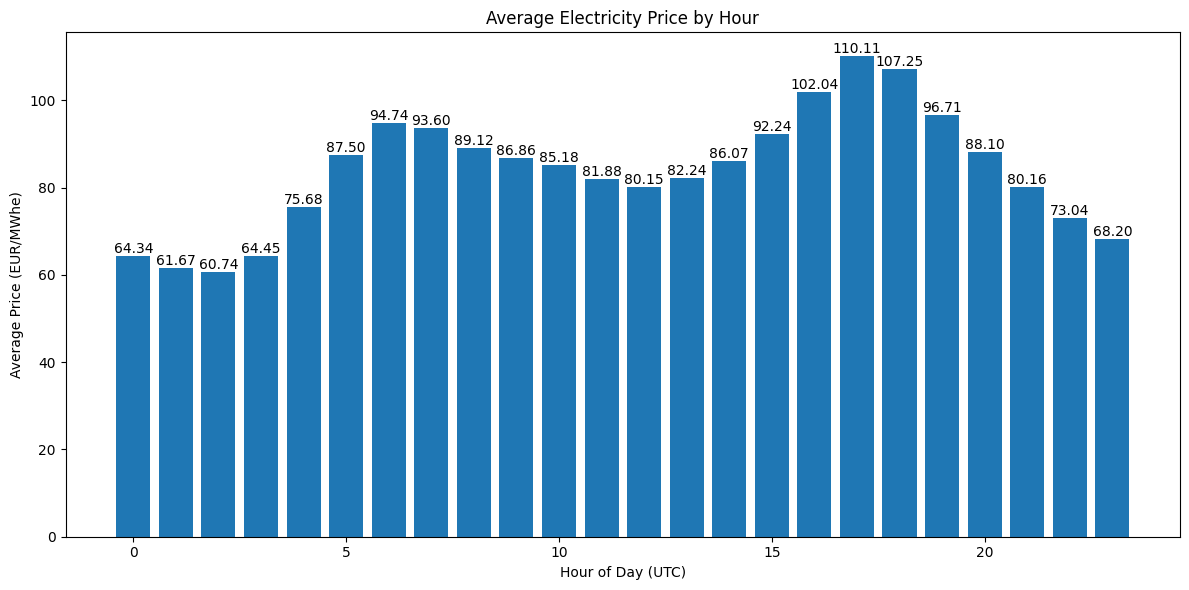

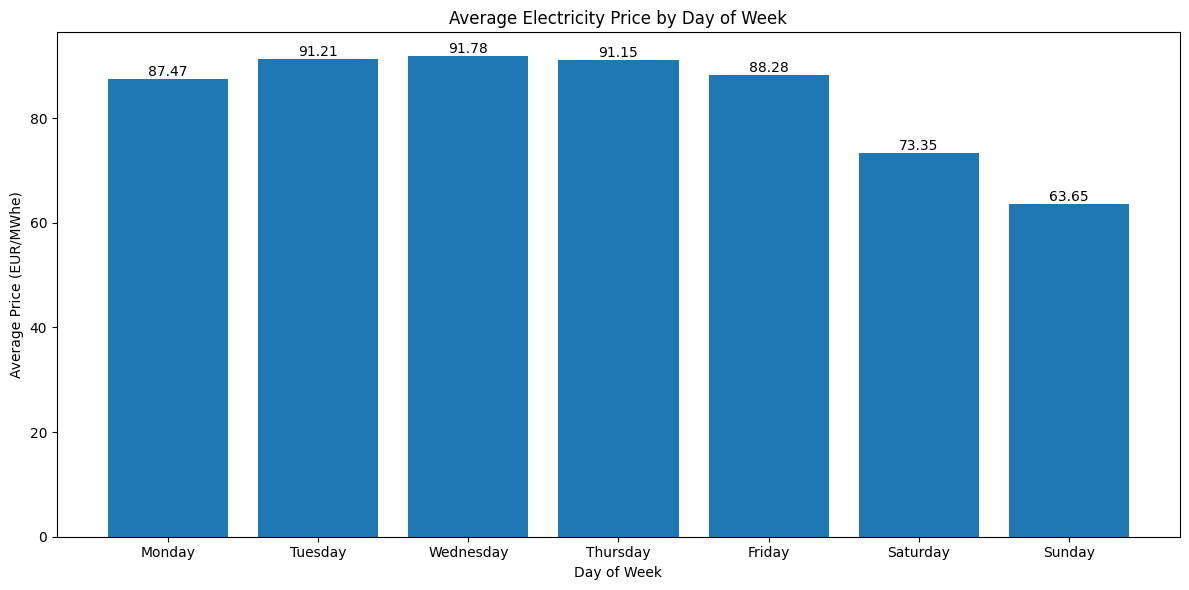

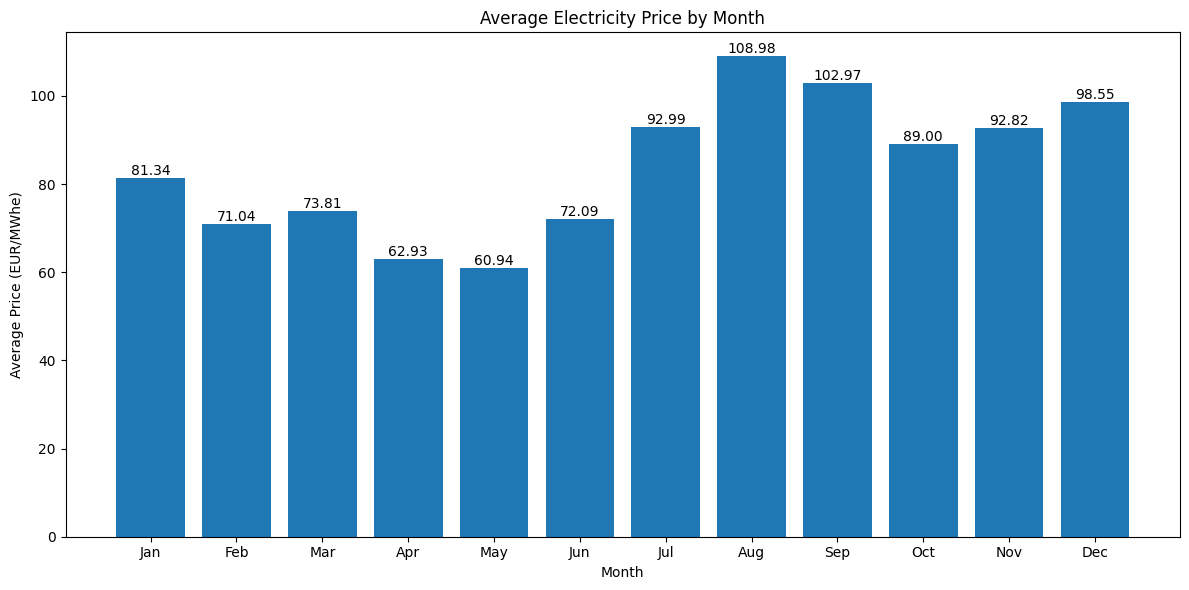

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('european_wholesale_electricity_price_data_hourly/Slovenia.csv')
df['Datetime (UTC)'] = pd.to_datetime(df['Datetime (UTC)'])
df['Hour'] = df['Datetime (UTC)'].dt.hour
df['Day of Week'] = df['Datetime (UTC)'].dt.dayofweek
df['Month'] = df['Datetime (UTC)'].dt.month


def plot_averages(data, x_column, y_column, title, xlabel, ylabel, rotation=0):
    plt.figure(figsize=(12, 6))
    plt.bar(data[x_column], data[y_column])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(rotation=rotation)
    for i, v in enumerate(data[y_column]):
        plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')
    plt.tight_layout()
    plt.show()

hourly_avg = df.groupby('Hour')['Price (EUR/MWhe)'].mean().reset_index()
hourly_avg = hourly_avg.sort_values('Hour')
plot_averages(hourly_avg, 'Hour', 'Price (EUR/MWhe)', 
              'Average Electricity Price by Hour', 'Hour of Day (UTC)', 'Average Price (EUR/MWhe)')


day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daily_avg = df.groupby('Day of Week')['Price (EUR/MWhe)'].mean().reset_index()
daily_avg = daily_avg.sort_values('Day of Week')
daily_avg['Day Name'] = daily_avg['Day of Week'].apply(lambda x: day_names[x])
plot_averages(daily_avg, 'Day Name', 'Price (EUR/MWhe)', 
              'Average Electricity Price by Day of Week', 'Day of Week', 'Average Price (EUR/MWhe)')


month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
monthly_avg = df.groupby('Month')['Price (EUR/MWhe)'].mean().reset_index()
monthly_avg = monthly_avg.sort_values('Month')
monthly_avg['Month Name'] = monthly_avg['Month'].apply(lambda x: month_names[x-1])
plot_averages(monthly_avg, 'Month Name', 'Price (EUR/MWhe)', 
              'Average Electricity Price by Month', 'Month', 'Average Price (EUR/MWhe)')


Podatki so v skladu s pričakovanji. Preverimo še škatle z brki.

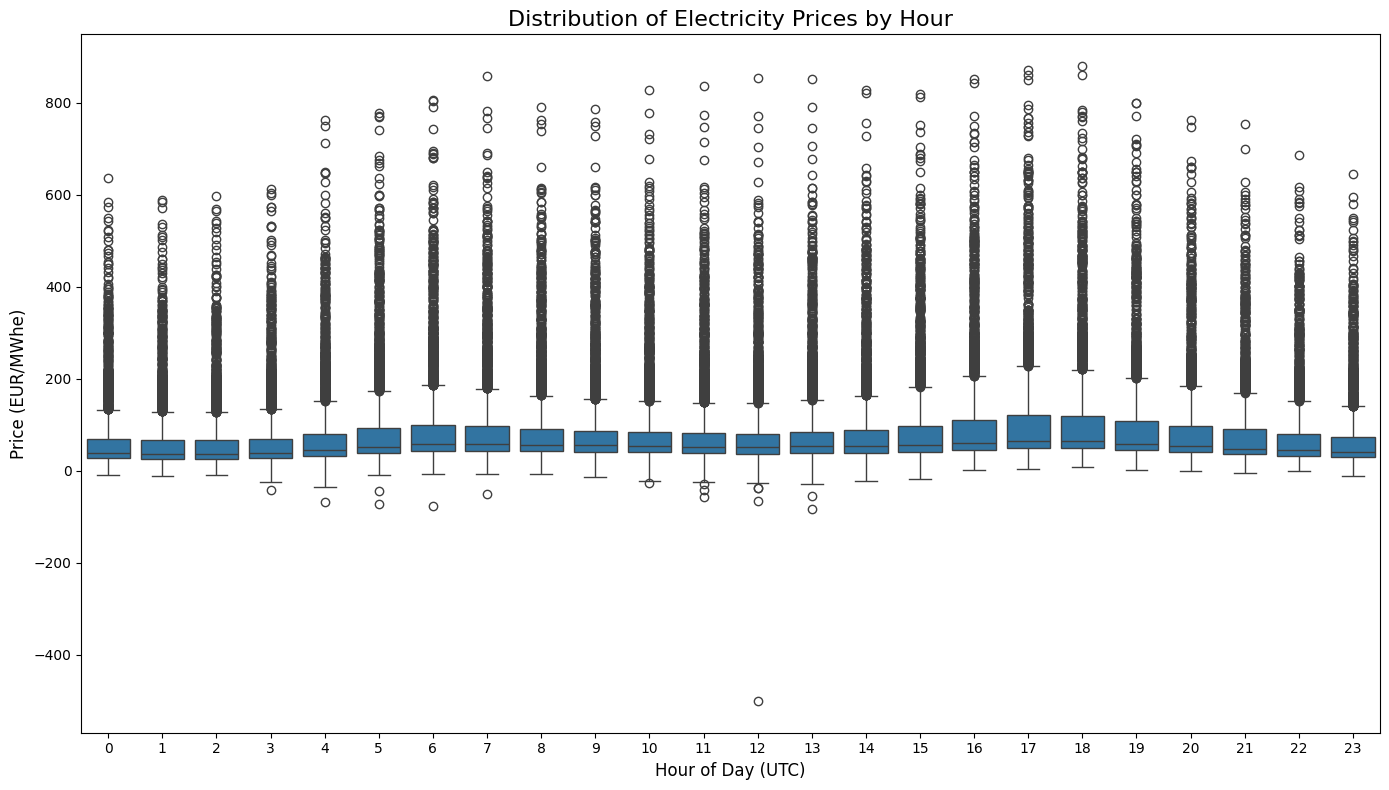

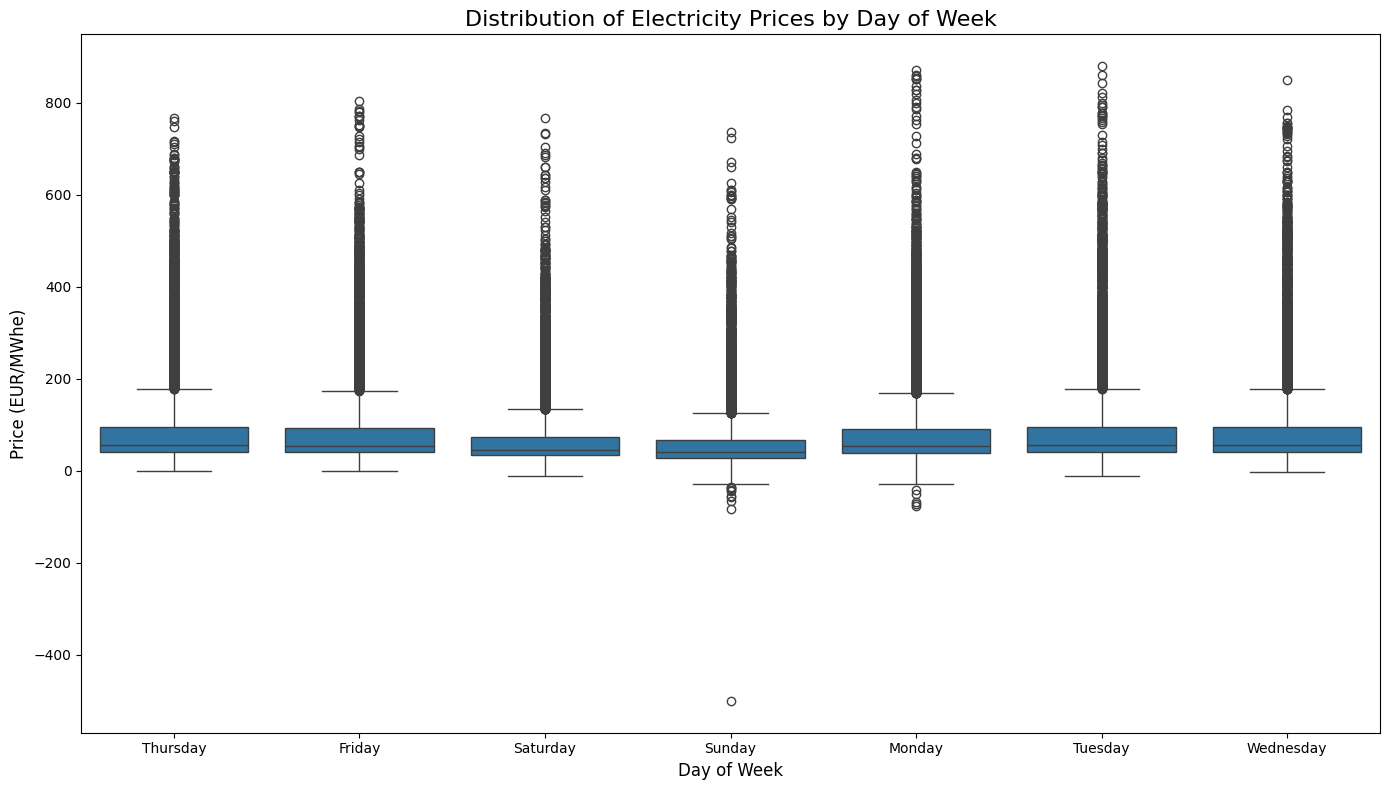

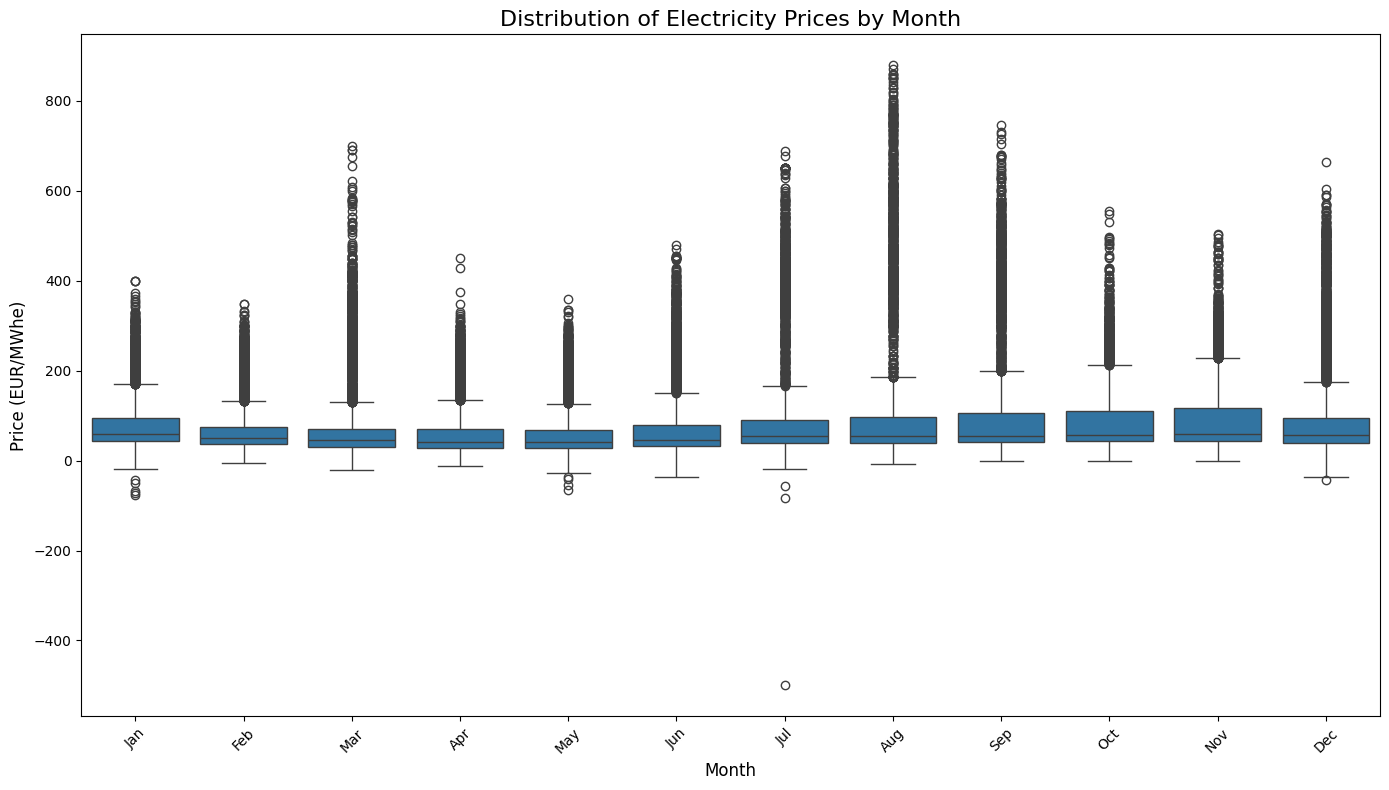

Hourly Summary Statistics:
       count        mean         std     min      25%     50%       75%  \
Hour                                                                      
0     3378.0   64.337774   71.842785   -8.61  27.6300  38.175   69.8150   
1     3378.0   61.667510   69.821625  -11.03  25.6850  36.785   66.7675   
2     3378.0   60.740708   69.266129   -9.56  25.2025  36.055   65.9600   
3     3378.0   64.447638   73.358794  -42.50  27.1000  38.035   69.9725   
4     3378.0   75.676015   84.889681  -67.00  32.8425  44.925   80.4250   
5     3378.0   87.496107   95.321155  -72.54  38.9200  52.605   92.5975   
6     3378.0   94.739748  100.156004  -76.01  43.0225  58.260  100.1700   
7     3378.0   93.603837   96.668580  -50.00  43.4575  59.075   97.5500   
8     3378.0   89.118777   91.948988   -5.95  42.0125  57.000   90.6375   
9     3378.0   86.858049   90.407942  -14.19  41.0100  55.665   86.7050   
10    3378.0   85.182999   89.730298  -25.61  40.8425  54.410   85.0875  

In [9]:
import seaborn as sns

def plot_box(data, x_column, y_column, title, xlabel, ylabel, rotation=0):
    plt.figure(figsize=(14, 8))
    sns.boxplot(x=x_column, y=y_column, data=data)
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.xticks(rotation=rotation)
    plt.tight_layout()
    plt.show()


plot_box(df, 'Hour', 'Price (EUR/MWhe)', 
         'Distribution of Electricity Prices by Hour', 
         'Hour of Day (UTC)', 'Price (EUR/MWhe)')


day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df['Day Name'] = df['Day of Week'].apply(lambda x: day_names[x])
plot_box(df, 'Day Name', 'Price (EUR/MWhe)', 
         'Distribution of Electricity Prices by Day of Week', 
         'Day of Week', 'Price (EUR/MWhe)')


month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df['Month Name'] = df['Month'].apply(lambda x: month_names[x-1])
plot_box(df, 'Month Name', 'Price (EUR/MWhe)', 
         'Distribution of Electricity Prices by Month', 
         'Month', 'Price (EUR/MWhe)', rotation=45)

print("Hourly Summary Statistics:")
print(df.groupby('Hour')['Price (EUR/MWhe)'].describe())
print("\nDaily Summary Statistics:")
print(df.groupby('Day Name')['Price (EUR/MWhe)'].describe())
print("\nMonthly Summary Statistics:")
print(df.groupby('Month Name')['Price (EUR/MWhe)'].describe())

In [10]:
# osredotočimo se na dnevno nihanje
# v predoločen sistem dodamo sin(2xpi/k) cos(...) kjer je k = 24 saj imamo urne podatke. dodamo še afin del a_1 * cene[-1]
import random
def ciklicni_prediktor(cene, k, m=-20000, utezi=[]):
    l = len(cene)
    if not utezi or len(cene) % t.zacetni_cas == 0: # uteži ne posodabljamo vsakič zaradi računske zahtevnosti
        utezi.clear()
        t0 = np.linspace(0, 2 * np.pi * len(cene)/k, len(cene))
        t0 = t0[m:]
        cene = cene[m:]
        
        cos_window = np.cos(t0)
        sin_window = np.sin(t0)
        
        matrika_cen = np.array([[1] * (len(cene) - 1), cos_window[:-1], sin_window[:-1]]) * np.array(cene[:-1])
        b = np.array(cene[1:])
        solution, _, _, _ = np.linalg.lstsq(matrika_cen.T, b, rcond=None)
        for i in solution:
            utezi.append(i)

    return (np.array([cene[-1], cene[-1] * np.cos(2 * np.pi * l/k), cene[-1] * np.sin(2 * np.pi * l/k)]) * np.array(utezi)).sum()
    # return (np.array([cos_window[-1], sin_window[-1]]) * solution).sum()

for i in [float("inf"), 1, 2, 3, 6, 12, 24, 2 * 24, 7 * 24, 365/12 * 24 ,365.25/4 * 24, 365.25/2 * 24, 365.25 * 24]:
    print()
    print(f"Cikli {i} ur")
    t.test(lambda x: ciklicni_prediktor(x, i))


Cikli inf ur
test <lambda>: povprecna kvadratna napaka: 241.7206746909873 porabljen cas: 0.3683047294616699

Cikli 1 ur
test <lambda>: povprecna kvadratna napaka: 241.69333357799368 porabljen cas: 0.36876749992370605

Cikli 2 ur
test <lambda>: povprecna kvadratna napaka: 241.77343130413126 porabljen cas: 0.3698911666870117

Cikli 3 ur
test <lambda>: povprecna kvadratna napaka: 241.72024229259665 porabljen cas: 0.37093281745910645

Cikli 6 ur
test <lambda>: povprecna kvadratna napaka: 227.10290390148907 porabljen cas: 0.372206449508667

Cikli 12 ur
test <lambda>: povprecna kvadratna napaka: 194.10816738354822 porabljen cas: 0.3728673458099365

Cikli 24 ur
test <lambda>: povprecna kvadratna napaka: 232.57362450600547 porabljen cas: 0.3739967346191406

Cikli 48 ur
test <lambda>: povprecna kvadratna napaka: 241.72784223083346 porabljen cas: 0.37836599349975586

Cikli 168 ur
test <lambda>: povprecna kvadratna napaka: 241.59550455247444 porabljen cas: 0.38587164878845215

Cikli 730.0 ur
tes

Upazimo, da je rezultat boljši, če je nihanje propercionalni ceni, kar ni preveč presenetljivo.
Preverimo ali se kaj spremeni, če dodamo višje harmonike sinusa in kosinusa.

In [11]:
def ciklicni_prediktor_s_harmoniki(cene, h, k, m=-20000, utezi=[]):
    l = len(cene)
    if not utezi or len(cene) % t.zacetni_cas == 0: # uteži ne posodabljamo vsakič zaradi računske zahtevnosti
        
        utezi.clear()

        t0 = np.linspace(0, 2 * np.pi * len(cene)/k, len(cene))
        t0 = t0[m:]
        cene = cene[m:]
        
        matrika_cen = np.array([[1] * (len(cene) - 1)] + [np.cos(i * t0)[:-1] for i in range(1, h + 1)] + 
                               [np.sin(i * t0)[:-1] for i in range(1, h + 1)]) * np.array(cene[:-1])
        b = np.array(cene[1:])
        solution, _, _, _ = np.linalg.lstsq(matrika_cen.T, b, rcond=None)
        for i in solution:
            utezi.append(i)

    return cene[-1] * (np.array([1] + [np.cos(i * 2 * np.pi * l/k) for i in range(1, h + 1)] + 
                               [np.sin(i * 2 * np.pi * l/k) for i in range(1, h + 1)]) * np.array(utezi)).sum()
    # return (np.array([cos_window[-1], sin_window[-1]]) * solution).sum()

for i, j in [(i, j) for i in [1, 2, 3, 4, 7, 14, 28, 365] for j in [12, 24, 7 * 24, 365.25 * 24]]:
    print()
    print(f"Cikli {j} ur s {i} harmoniki")
    t.test(lambda x: ciklicni_prediktor_s_harmoniki(x, i, j))


Cikli 12 ur s 1 harmoniki
test <lambda>: povprecna kvadratna napaka: 194.10816738354822 porabljen cas: 0.5629839897155762

Cikli 24 ur s 1 harmoniki
test <lambda>: povprecna kvadratna napaka: 232.57362450600547 porabljen cas: 0.4872722625732422

Cikli 168 ur s 1 harmoniki
test <lambda>: povprecna kvadratna napaka: 241.59550455247438 porabljen cas: 0.45046424865722656

Cikli 8766.0 ur s 1 harmoniki
test <lambda>: povprecna kvadratna napaka: 241.73255045709823 porabljen cas: 0.44439196586608887

Cikli 12 ur s 2 harmoniki
test <lambda>: povprecna kvadratna napaka: 183.09517091305693 porabljen cas: 0.5602190494537354

Cikli 24 ur s 2 harmoniki
test <lambda>: povprecna kvadratna napaka: 183.00123276602613 porabljen cas: 0.5989859104156494

Cikli 168 ur s 2 harmoniki
test <lambda>: povprecna kvadratna napaka: 241.4260084171343 porabljen cas: 0.5788235664367676

Cikli 8766.0 ur s 2 harmoniki
test <lambda>: povprecna kvadratna napaka: 241.7084135014701 porabljen cas: 0.5668742656707764

Cikli

Najboljša rezultata:

Cikli 24 ur s 7 harmoniki
test povprecna kvadratna napaka: 166.9815273098984 porabljen cas: 1.1390209197998047

Cikli 168 ur s 28 harmoniki
test povprecna kvadratna napaka: 165.84259607364783 porabljen cas: 3.6145482063293457

Pomembno opažanje tudi:

Cikli 24 ur s 28 harmoniki
test <lambda>: povprecna kvadratna napaka: 172.86080527896382 porabljen cas: 3.616105079650879

Cikli 168 ur s 365 harmoniki
test <lambda>: povprecna kvadratna napaka: 216.36783751095797 porabljen cas: 47.15390586853027


Sklepamo, da tedenske periode tudi pripormorejo, ampak ne želimo dodati vseh harmonikov saj po nepotrebnem povečajo varianco modelov.

In [12]:
def kombinacije(cene, harmoniki_frekvence, m=-20000, utezi=[]):
    l = len(cene)
    if not utezi or len(cene) % t.zacetni_cas == 0:
        utezi.clear()
        t0 = np.linspace(0, 2 * np.pi * len(cene), len(cene))
        t0 = t0[m:]
        cene = cene[m:]
        
        b = np.array(cene[1:])
        cene_ = np.array(cene[:-1])
        matrika_cen = np.array([cene_])
        
        for (h, k) in harmoniki_frekvence:
            for i in range(1, h + 1):
                t0_ = t0 / k * i
                cos_row = cene_ * np.cos(t0_)[:-1]
                matrika_cen = np.vstack([matrika_cen, cos_row])
                
        for (h, k) in harmoniki_frekvence:
            for i in range(1, h + 1):
                t0_ = t0 / k * i
                sin_row = cene_ * np.sin(t0_)[:-1]
                matrika_cen = np.vstack([matrika_cen, sin_row])
            
        solution, _, _, _ = np.linalg.lstsq(matrika_cen.T, b, rcond=None)
        utezi.extend(solution)
        
    # base_cos_sin = np.array([1] + sum([[np.cos(i * 2 * np.pi * l / k) for i in range(1, h + 1)] + 
    #         [np.sin(i * 2 * np.pi * l / k) for i in range(1, h + 1)] for (h, k) in harmoniki_frekvence], []))

    base_cos_sin = [1]
    base_cos_sin += [(np.cos(2 * np.pi * l * i / k)) for (h, k) in harmoniki_frekvence for i in range(1, h + 1)] 
    base_cos_sin += [(np.sin(2 * np.pi * l * i / k)) for (h, k) in harmoniki_frekvence for i in range(1, h + 1)] 
            
    return cene[-1] * (base_cos_sin * np.array(utezi)).sum()

# v splošnem (8, 24) dela najbolje zato sem to vrednost kar fiksiral
nastavitve = [[(k, 24 * 365.25), (j, 24 * 7), (8, 24)] for k in [0,1,2,3,6,12,24] for j in range(7)]
for i in nastavitve:
    print(f"Seznam {i}")
    t.test(lambda x: kombinacije(x, i))

Seznam [(0, 8766.0), (0, 168), (8, 24)]
test <lambda>: povprecna kvadratna napaka: 167.0418550639411 porabljen cas: 1.37469482421875
Seznam [(0, 8766.0), (1, 168), (8, 24)]
test <lambda>: povprecna kvadratna napaka: 166.91309537496008 porabljen cas: 1.4494602680206299
Seznam [(0, 8766.0), (2, 168), (8, 24)]
test <lambda>: povprecna kvadratna napaka: 166.74862628451453 porabljen cas: 1.6876485347747803
Seznam [(0, 8766.0), (3, 168), (8, 24)]
test <lambda>: povprecna kvadratna napaka: 166.6876962528339 porabljen cas: 1.686783790588379
Seznam [(0, 8766.0), (4, 168), (8, 24)]
test <lambda>: povprecna kvadratna napaka: 166.63849317608774 porabljen cas: 1.8105971813201904
Seznam [(0, 8766.0), (5, 168), (8, 24)]
test <lambda>: povprecna kvadratna napaka: 166.3870679274682 porabljen cas: 2.016613006591797
Seznam [(0, 8766.0), (6, 168), (8, 24)]
test <lambda>: povprecna kvadratna napaka: 165.93583643772848 porabljen cas: 2.087216377258301
Seznam [(1, 8766.0), (0, 168), (8, 24)]
test <lambda>: p

Najmanjšo napako vidimo pri:<br> 

Seznam [(3, 8766.0), (6, 168), (8, 24)] // (št. harmonikov, ferkvenca)<br> 
test \<lambda>: povprecna kvadratna napaka: 165.7173561632939 porabljen cas: 2.5357277393341064,<br> 

vendar natančna izbira ni zelo pomembna.

Prvotno sem želel izbiro: <br> 

Seznam [(24, 8766.0), (6, 168), (8, 24)]<br> 
test \<lambda>: povprecna kvadratna napaka: 165.8415227758638 porabljen cas: 4.8590333461761475,<br> 

saj se mi zdi konceptualno bolj čista razlika v napaki ni občutna. Ideja: ferkvenca 24/leto je okoli 14 dni (v resnici 15,2). To razpolovimo s tednsko osnovo, ta pa ima 6 harmonikov. Naslednji harmonik se ujema z dnevno frkvenco in dodamo še nekaj harmonikov dnevne ferkvence.

Izbral bom najboljši rezultat, ne zato, ker je najboljši ampak ker ima manj parametrov (v nadaljevanju želim modele združiti). To, da ima 0,0008 % manjši MSE je irelevantno, saj bi ob sistematičnem testiranju in ob naknadni izbiri najboljšega rezultati delamo metodloško napako.

Za sedaj bom prenehal z harmoničnimi modeli. Najbolji rezultat linearnega modela je boljši od harmoničnega.

umerjena linearna kombinacija 512 podatkov
test \<lambda>: povprecna kvadratna napaka: 131.91543977381758 porabljen cas: 7.114553213119507

Seznam \[(24, 8766.0), (6, 168), (8, 24)]
test \<lambda>: povprecna kvadratna napaka: 165.8415227758638 porabljen cas: 4.8590333461761475

V nadeljevanju želim preizkusiti linearni model, 
ki bi osnoval za geometrijsko obteženih vsota prejšnih cen z različnimi rapolovnimi časi. 
Še pred tem pa bom modela poiskusil združiti.

In [13]:
def primitivno_mesan(data):
    n_linear = 512 
    harmoniki_frekvence = [(8, 24), (6, 168), (3,24*365.25)]
    return (0.8 * linearni_prediktor(data, n_linear) + 0.2 * kombinacije(data, harmoniki_frekvence))

t.test(lambda x: primitivno_mesan(x))


test <lambda>: povprecna kvadratna napaka: 128.68541188274907 porabljen cas: 10.1982741355896


Ta rezultat je boljši od obeh posameznik, kar je zelo spodbudno.

In [14]:
def mesan(cene, n, harmoniki_frekvence, m=-20000, utezi=[]):
    l = len(cene)
    if not utezi or len(cene) % t.zacetni_cas == 0:
        utezi.clear()
        t0 = np.linspace(0, 2 * np.pi * len(cene), len(cene))
        t0 = t0[m:]
        cene = cene[m:]
        
        b = np.array(cene[n:])
        matrika_cen = np.array([cene[i:len(cene)-n+i] for i in range(n)])
        
        for (h, k) in harmoniki_frekvence:
            for i in range(1, h + 1):
                t0_ = t0 / k * i
                cos_values = np.cos(t0_)[n-1:-1]
                sin_values = np.sin(t0_)[n-1:-1]
                
                cos_row = cene[n-1:-1] * cos_values
                sin_row = cene[n-1:-1] * sin_values
                
                matrika_cen = np.vstack([matrika_cen, cos_row, sin_row])
        
        solution, *_ = np.linalg.lstsq(matrika_cen.T, b, rcond=None)
        utezi.extend(solution)
    
    base_terms = cene[-n:]
    for (h, k) in harmoniki_frekvence:
        for i in range(1, h + 1):
            angle = 2 * np.pi * l * i / k
            base_terms = np.append(base_terms, cene[-1] * np.cos(angle))
            base_terms = np.append(base_terms, cene[-1] * np.sin(angle))
    
    return (base_terms * np.array(utezi)).sum()


for i in range(12):
    print()
    print(f"model z {2**i} linearnimi cleni in {[(8, 24), (6, 168), (3,24*365.25)]} valovanji")
    t.test(lambda x: mesan(x, 2 ** i, [(8, 24), (6, 168), (3,24*365.25)]))



model z 1 linearnimi cleni in [(8, 24), (6, 168), (3, 8766.0)] valovanji
test <lambda>: povprecna kvadratna napaka: 165.7173561632939 porabljen cas: 8.951418161392212

model z 2 linearnimi cleni in [(8, 24), (6, 168), (3, 8766.0)] valovanji
test <lambda>: povprecna kvadratna napaka: 166.5180182498182 porabljen cas: 8.99864411354065

model z 4 linearnimi cleni in [(8, 24), (6, 168), (3, 8766.0)] valovanji
test <lambda>: povprecna kvadratna napaka: 165.55191542002314 porabljen cas: 8.960248708724976

model z 8 linearnimi cleni in [(8, 24), (6, 168), (3, 8766.0)] valovanji
test <lambda>: povprecna kvadratna napaka: 162.17936633875968 porabljen cas: 8.958423852920532

model z 16 linearnimi cleni in [(8, 24), (6, 168), (3, 8766.0)] valovanji
test <lambda>: povprecna kvadratna napaka: 158.5152085648358 porabljen cas: 9.156543493270874

model z 32 linearnimi cleni in [(8, 24), (6, 168), (3, 8766.0)] valovanji
test <lambda>: povprecna kvadratna napaka: 141.53987421501662 porabljen cas: 9.4386

In [15]:
def linearni_prediktor(cene, n, m=-20000, utezi=[], reset=False):
    if not utezi or reset:
        utezi.clear()
        cene = cene[m:]
        matrika_cen = np.array([cene[i:i-n] for i in range(n)])
        b = np.array(cene[n:])
        solution, _, _, _ = np.linalg.lstsq(matrika_cen.T, b, rcond=None)
        for i in solution:
            utezi.append(i)
    return (np.array(cene[-n:]) * np.array(utezi)).sum()


def boosting(cene, n, harmoniki_frekvence, m=-20000, alpha=0.5, errors=[], funcs=[], reset=False):
    # First stage: kombinacije prediction
    if len(cene) == t.zacetni_cas:
        errors.clear()
        funcs.clear()
        
    if not funcs:
        funcs.append(lambda x: kombinacije(x, harmoniki_frekvence))
        funcs.append(lambda x, y: linearni_prediktor(x, n, reset=y))

    
    
    reset = False


    # if random.random() <0.01:
    #     print(len(cene), reset,  not errors , len(cene) % t.zacetni_cas == 0, errors[:10])
    
    if not errors or len(cene) % t.zacetni_cas == 0:
        errors.clear()
        errors.extend(list(np.array(cene[n+10:]) - np.array([funcs[0](cene[:i]) for i in range(n+10, len(cene))])))
        reset = True
    else:
        errors.append(cene[-1] - funcs[0](cene))
        
    error_pred = funcs[1](errors, reset)

    final_pred = funcs[0](cene) + alpha * error_pred
    
    return final_pred


for i in range(10):
    print(f"\nBoosting z {2**i} linearnimi deli")
    t.test(lambda x: boosting(x, 2**i, [(8, 24), (6, 168), (3,24*365.25)]))



Boosting z 1 linearnimi deli
test <lambda>: povprecna kvadratna napaka: 166.22433557356226 porabljen cas: 31.808448791503906

Boosting z 2 linearnimi deli
test <lambda>: povprecna kvadratna napaka: 166.53175982561666 porabljen cas: 31.504575729370117

Boosting z 4 linearnimi deli
test <lambda>: povprecna kvadratna napaka: 167.67369716259236 porabljen cas: 31.256254196166992

Boosting z 8 linearnimi deli
test <lambda>: povprecna kvadratna napaka: 168.1336156613034 porabljen cas: 32.13577914237976

Boosting z 16 linearnimi deli
test <lambda>: povprecna kvadratna napaka: 167.52655530495267 porabljen cas: 31.73894214630127

Boosting z 32 linearnimi deli
test <lambda>: povprecna kvadratna napaka: 167.9400129266652 porabljen cas: 31.79591155052185

Boosting z 64 linearnimi deli
test <lambda>: povprecna kvadratna napaka: 169.72776818061737 porabljen cas: 32.12544918060303

Boosting z 128 linearnimi deli
test <lambda>: povprecna kvadratna napaka: 171.79192111521104 porabljen cas: 33.281617879

Do sedaj je primitivno mešan model najboljši.

umerjena linearna kombinacija 512 podatkov
test <lambda>: povprecna kvadratna napaka: 131.91543977381758 porabljen cas: 7.114553213119507

Seznam \[(24, 8766.0), (6, 168), (8, 24)]
test <lambda>: povprecna kvadratna napaka: 165.8415227758638 porabljen cas: 4.8590333461761475

Primitivno mesan
test <lambda>: povprecna kvadratna napaka: 128.68541188274907 porabljen cas: 9.456538915634155

model z 512 linearnimi cleni in \[(8, 24), (6, 168), (3, 8766.0)] valovanji
test <lambda>: povprecna kvadratna napaka: 131.4013507646435 porabljen cas: 17.360899686813354


Domneva: zmanjšat moram varianco modelov (št. parametrov).